In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white, het_breuschpagan, het_goldfeldquandt, linear_reset

In [2]:
df = pd.read_csv('transactions-2023-01-11.csv')

In [3]:
def drop_excess_columns(data):
    # Drop high cardinality columns
    data = data.drop(columns=["Transaction Number", "Property ID", "Transaction Size (sq.m)", "Parking", "Project"])
    # Drop low-cardinality columns
    data = data.drop(columns=["Registration type", "Master Project"])
    # Drop leaky columns
    data = data.drop(columns=["Transaction sub type", "Property Type", "Room(s)", "No. of Buyer", "No. of Seller", 'Nearest Mall', 'Nearest Landmark'])
    return data


In [4]:
df = drop_excess_columns(df)

In [5]:
# def get_oil_price():
#     # data from https://tradingeconomics.com/commodity/crude-oil
#     r = requests.get('https://markets.tradingeconomics.com/chart?s=cl1:com&interval=1d&span=5y&securify=new&url=/commodity/crude-oil&AUTH=j6Bt4pj3JEXdfgKlsPWa%2BhKpyYuaZeaGdJeVvofKg%2F50KkIli0%2Fe4jDtQXrDXz5r&ohlc=0')
    
#     oil_data = pd.DataFrame(r.json()['series'][0]['data']).rename(columns={"y": "Oil Price"})
#     oil_data = oil_data[(oil_data['date'] > '2021-03-01') & (oil_data['date'] < '2022-02-04')]

#     return oil_data[['date', 'Oil Price']]
    

In [6]:
# oil_data = get_oil_price()
# oil_data.to_csv (r'oil_data.csv')
# oil_data

In [7]:
oil_data = pd.read_csv('oil_data.csv', index_col=0)
oil_data.head(2)

,date,Oil Price
858,2021-03-01T00:00:00,60.64
859,2021-03-02T00:00:00,59.75


In [8]:
def drop_period_after_war(data):
    war_date = '2022-02-24'
    return data[data['Transaction Date'] < war_date]

In [9]:
df = drop_period_after_war(df)

In [10]:
def merge_oil_to_data(data, oil):
    data['date_without_time'] = pd.to_datetime(data['Transaction Date']).dt.strftime('%Y-%m-%d')
    oil['date_without_time'] = pd.to_datetime(oil['date']).dt.strftime('%Y-%m-%d')
    data = data.merge(oil, left_on='date_without_time', right_on='date_without_time')
    return data

In [11]:
df = merge_oil_to_data(df, oil_data)

In [12]:
df.head(3)

,Transaction Date,Transaction Type,Is Free Hold?,Usage,Area,Property Sub Type,Amount,Property Size (sq.m),Nearest Metro,date_without_time,date,Oil Price
0,2021-03-02 13:53:10,Mortgage,Free Hold,Residential,AL BARARI,Flat,1435909.09,138.93,NaN,2021-03-02,2021-03-02T00:00:00,59.75
1,2021-03-02 13:53:10,Mortgage,Free Hold,Residential,AL BARARI,Flat,1435909.09,87.26,NaN,2021-03-02,2021-03-02T00:00:00,59.75
2,2021-03-02 13:53:10,Mortgage,Free Hold,Residential,AL BARARI,Flat,1435909.09,76.13,NaN,2021-03-02,2021-03-02T00:00:00,59.75


In [13]:
def clean_outliers_in_data(data):
    quantiles = data.quantile(0.98)
    data = data[(data['Amount'] < quantiles['Amount']) & (data['Property Size (sq.m)'] < quantiles['Property Size (sq.m)'])]
    data = data[data['Property Sub Type'].isin(["Commercial", "Flat", "Hotel Apartment", "Hotel Rooms",  "Office", "Residential", "Residential / Attached Villas","Residential Flats", "Stacked Townhouses", "Villa"])]
    data = data.dropna()
    return data

In [14]:
cleaned_df = clean_outliers_in_data(df)

C:\Users\idtyu\AppData\Local\Temp\ipykernel_21364\708482841.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles = data.quantile(0.98)


In [15]:
cleaned_df.head(3)

,Transaction Date,Transaction Type,Is Free Hold?,Usage,Area,Property Sub Type,Amount,Property Size (sq.m),Nearest Metro,date_without_time,date,Oil Price
119,2021-03-02 08:12:18,Sales,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Flat,605350.0,60.81,Nakheel Metro Station,2021-03-02,2021-03-02T00:00:00,59.75
120,2021-03-02 08:12:26,Sales,Free Hold,Residential,BURJ KHALIFA,Flat,2244888.0,98.61,Buj Khalifa Dubai Mall Metro Station,2021-03-02,2021-03-02T00:00:00,59.75
121,2021-03-02 08:12:43,Sales,Free Hold,Residential,DUBAI MARINA,Hotel Rooms,639275.0,7.87,Mina Seyahi,2021-03-02,2021-03-02T00:00:00,59.75


In [16]:
from pandas.plotting import scatter_matrix

def plot_matrix(data):
    scatter_matrix(data[['Amount', 'Property Size (sq.m)']], figsize=(12, 8))
    scatter_matrix(data[['Amount', 'Oil Price']], figsize=(12, 8))
    return data['Property Size (sq.m)'].describe()

In [ ]:
plot_matrix(cleaned_df)

In [17]:
def preparing_data_before_training(data, drop, renameColumns):
    data = data.drop(drop, axis=1)
    data = data.rename(columns=renameColumns)
    return data

In [85]:
prepared_data = preparing_data_before_training(
    cleaned_df, 
    ['date_without_time', 'Transaction Date', 'date'],
    {
        'Property Size (sq.m)': 'Property_Size',
        'Property Sub Type': 'Property_Sub_Type',
        'Nearest Metro': 'Nearest_Metro',
        'Nearest Mall': 'Nearest_Mall',
        'Nearest Landmark': 'Nearest_Landmark',
        'Oil Price': 'Oil_Price',
        'Transaction Type': 'Transaction_Type',
        "Is Free Hold?": 'Is_Free_Hold'
    }
)

In [87]:
import statsmodels.formula.api as smf #  + C(Nearest_Mall) + C(Nearest_Landmark) 
formula = 'Amount ~ C(Transaction_Type) + C(Usage) + C(Area) + C(Property_Sub_Type) + Property_Size + C(Nearest_Metro)+ Oil_Price + C(Is_Free_Hold)'
sm_data = sm.add_constant(prepared_data)
model = smf.ols(formula=formula, data=sm_data)
results = model.fit()


In [20]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Amount   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     433.8
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:41:36   Log-Likelihood:            -6.9300e+05
No. Observations:               45097   AIC:                         1.386e+06
Df Residuals:                   44894   BIC:                         1.388e+06
Df Model:                         202                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                  1.83e+06   2.06e+05      8.870      0.000    1.43e+06    2.23e+06
C(Transaction_Type)[T.Mortgage]                          -1.795e+05   2.85e+04     -6.290      0.000   -2.35e+05   -1.24e+05
C(Transaction_Type)[T.Sales]                              5.284e+05   2.72e+04     19.418      0.000    4.75e+05    5.82e+05
C(Usage)[T.Residential]                                  -1.548e+05   3.83e+04     -4.040      0.000    -2.3e+05   -7.97e+04
C(Area)[T.AL FURJAN]                                     -2.272e+06    1.3e+05    -17.501      0.000   -2.53e+06   -2.02e+06
C(Area)[T.AL KHAIL HEIGHTS]                              -2.744e+06   2.16e+05    -12.700      0.000   -3.17e+06   -2.32e+06
C(Area)[T.ARABIAN RANCHES I]                             -3.403e+06   2.34e+05    -14.574      0.000   -3.86e+06   -2.95e+06
C(Area)[T.ARJAN]                                         -2.345e+06   2.21e+05    -10.628      0.000   -2.78e+06   -1.91e+06
C(Area)[T.Abu Hail]                                      -2.119e+06   8.02e+05     -2.643      0.008   -3.69e+06   -5.48e+05
C(Area)[T.Al Bada]                                        -1.08e+06   5.56e+05     -1.944      0.052   -2.17e+06    8990.028
C(Area)[T.Al Baraha]                                     -1.278e+05   6.49e+05     -0.197      0.844    -1.4e+06    1.14e+06
C(Area)[T.Al Barsha First]                                -1.59e+06   4.69e+05     -3.389      0.001   -2.51e+06    -6.7e+05
C(Area)[T.Al Barsha Second]                              -5.238e+06   3.39e+05    -15.459      0.000    -5.9e+06   -4.57e+06
C(Area)[T.Al Barsha Third]                               -4.737e+06   3.42e+05    -13.837      0.000   -5.41e+06   -4.07e+06
C(Area)[T.Al Barshaa South First]                        -5.139e+06   4.95e+05    -10.372      0.000   -6.11e+06   -4.17e+06
C(Area)[T.Al Barshaa South Third]                        -2.791e+06   6.97e+05     -4.006      0.000   -4.16e+06   -1.43e+06
C(Area)[T.Al Dhagaya]                                    -5.282e+06   9.54e+05     -5.536      0.000   -7.15e+06   -3.41e+06
C(Area)[T.Al Garhoud]                                    -6.155e+04   4.25e+05     -0.145      0.885   -8.94e+05    7.71e+05
C(Area)[T.Al Goze First]                                 -4.168e+06    3.5e+05    -11.924      0.000   -4.85e+06   -3.48e+06
C(Area)[T.Al Goze Fourth]                                -2.594e+06   8.42e+05     -3.080      0.002   -4.25e+06   -9.43e+05
C(Area)[T.Al Goze Second]                                -6.304e+06   7.03e+05     -8.969      0.000   -7.68e+06   -4.93e+06
C(Area)[T.Al Hamriya]                                     7.264e+06    1.2e+06     

In [ ]:
fig = sm.graphics.plot_regress_exog(results, "Property_Size")
fig.tight_layout(pad=1.0);

In [ ]:
pred_ols = results.get_prediction()

fig, ax = plt.subplots(figsize=(8, 6))

x = prepared_data['Property_Size']
y = prepared_data['Amount']

ax.plot(x, y, "o", label="data")
ax.plot(x, results.fittedvalues, "o", label="OLS")

ax.legend(loc="best");

$\DeclareMathOperator{\Corr}{Corr}$
# Multicollinearity

###### def:Multicollinearity is a linear relationship between explanatory variables. =>  $Corr(X_i, X_j) > 0$
###### When we face multicollinearity:
1. When regressors mean relatively the same (ex: height of a building and number of floors)
2. Natural relationships between variables (ex: year of work and age)

###### Consequences of multicollinearity:
1. Estimates __remain unbiased__
2. Increased standard errors
3. Wide confidence intervals
4. Insignificant coefficients
5. Estimates become sensitive to slight changes

###### How to detect multicollinearity:
1. small changes lead to serious changes in estimates
2. insignificant estimates due to big standard errors
3. unexpected signs of estimates

###### Indicators of multicollinearity:
1. Strong covariance between regressors - calculate sample Var-Cov matrix
2. Large value of VIF (Variance inflation factor) <br>
$ VIF(x_j) = \frac{1}{1 - R_j^2}$
,where $ R_j^2$ is determination coefficient for regression <br>
In VIF method, we pick each feature and regress it against all of the other features. Generally, a VIF above 5 indicates a high multicollinearity. <br>
https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

###### Dealing with multicollinearity: (ЖЕЛАТЕЛЬНО ДОПОЛНИТЬ)
1. Increase sample size
2. Change functional form
3. Impose some priory restrictions on parameters
4. Dimension reduction / Principal component analysis (PCA)
5. Ridge and LASSO regressions

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy

def VIF(data, formula):  # from explanatory matrix and formula
    """
    Calculates VIF coefficients for given dataframe. Returns DataFrame.
    
    Arguments:
    data - DataFrame that have been used in regression
    formula - Formula used in regression as a string, example: 'Amount ~ C(Transaction_Type) + C(Area)'
    
    Interpretation:
    The variance inflation factor is a measure for the increase of the variance of the parameter estimates 
    if an additional variable, given by exog_idx is added to the linear regression. 
    It is a measure for multicollinearity of the design matrix, exog.

    One recommendation is that if VIF is greater than 5, 
    then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables,
    and the parameter estimates will have large standard errors because of this.
        
    Sources:
    https://en.wikipedia.org/wiki/Variance_inflation_factor
    https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
    
    """
    f = formula  
    y, X = patsy.dmatrices(f, data, return_type='matrix')

    vif_data = pd.DataFrame()
    vif_data["feature"] = X.design_info.column_names

    vif_values = []
    for i in range(len(X.design_info.column_names)):
        vif_values.append(variance_inflation_factor(X, i))

    vif_data['VIF'] = vif_values
    return vif_data


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VIF2(model, results):  # from model
    """
    Calculates VIF coefficients for given model. Returns DataFrame.
    
    Arguments:
    model - fitted regression model from Statsmodels
    
    Interpretation:
    The variance inflation factor is a measure for the increase of the variance of the parameter estimates 
    if an additional variable, given by exog_idx is added to the linear regression. 
    It is a measure for multicollinearity of the design matrix, exog.

    One recommendation is that if VIF is greater than 5, 
    then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables,
    and the parameter estimates will have large standard errors because of this.
        
    Sources:
    https://en.wikipedia.org/wiki/Variance_inflation_factor
    https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
    
    """
    vif_data = pd.DataFrame()
    vif_data["feature"] = model.exog_names

    vif_values = []
    for i in range(len(model.exog_names)):
        vif_values.append(variance_inflation_factor(results.model.exog, i))

    vif_data['VIF'] = vif_values
    return vif_data

In [23]:
VIF = VIF(sm_data, 'Amount ~ C(Transaction_Type) + C(Usage) + C(Area) + C(Property_Sub_Type) + Property_Size + Oil_Price + C(Is_Free_Hold)')  # sm_data, 'Amount ~ C(Transaction_Type) + C(Area) + C(Nearest_Landmark) + Oil_Price + C(Is_Free_Hold)'
VIF.head(3)

C:\Users\idtyu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,Intercept,1509.815985
1,C(Transaction_Type)[T.Mortgage],5.518241
2,C(Transaction_Type)[T.Sales],5.496753


In [50]:
VIF.sort_values('VIF', ascending=False).head(10)

,feature,VIF
147,C(Property_Sub_Type)[T.Flat],inf
153,C(Property_Sub_Type)[T.Villa],inf
148,C(Property_Sub_Type)[T.Hotel Apartment],inf
3,C(Usage)[T.Residential],inf
149,C(Property_Sub_Type)[T.Hotel Rooms],inf
150,C(Property_Sub_Type)[T.Office],inf
151,C(Property_Sub_Type)[T.Residential],inf
152,C(Property_Sub_Type)[T.Residential Flats],inf
0,Intercept,1509.815985
62,C(Area)[T.BUSINESS BAY],143.433559


In [52]:
y_sub = pd.DataFrame(model.exog, columns=model.exog_names)['C(Property_Sub_Type)[T.Flat]']
X_sub = pd.DataFrame(model.exog, columns=model.exog_names).drop(columns='C(Property_Sub_Type)[T.Flat]')

In [56]:
model_sub = sm.OLS(y_sub, X_sub)
results_sub = model_sub.fit()

In [57]:
results_sub.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     C(Property_Sub_Type)[T.Flat]   R-squared:                       1.000
Model:                                      OLS   Adj. R-squared:                  1.000
Method:                           Least Squares   F-statistic:                 2.141e+27
Date:                          Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                                  18:27:29   Log-Likelihood:             1.2682e+06
No. Observations:                         45097   AIC:                        -2.536e+06
Df Residuals:                             44894   BIC:                        -2.534e+06
Df Model:                                   202                                         
Covariance Type:                      nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                -4.051e-13   2.68e-14    -15.131      0.000   -4.58e-13   -3.53e-13
C(Transaction_Type)[T.Mortgage]                           3.347e-14    3.7e-15      9.041      0.000    2.62e-14    4.07e-14
C(Transaction_Type)[T.Sales]                              1.811e-14   3.53e-15      5.128      0.000    1.12e-14     2.5e-14
C(Usage)[T.Residential]                                      1.0000   6.18e-15   1.62e+14      0.000       1.000       1.000
C(Area)[T.AL FURJAN]                                      5.769e-14   1.68e-14      3.425      0.001    2.47e-14    9.07e-14
C(Area)[T.AL KHAIL HEIGHTS]                               1.765e-13    2.8e-14      6.294      0.000    1.22e-13    2.31e-13
C(Area)[T.ARABIAN RANCHES I]                              1.718e-13   3.03e-14      5.670      0.000    1.12e-13    2.31e-13
C(Area)[T.ARJAN]                                          1.516e-13   2.86e-14      5.293      0.000    9.54e-14    2.08e-13
C(Area)[T.Abu Hail]                                        1.39e-14   1.04e-13      0.134      0.894    -1.9e-13    2.18e-13
C(Area)[T.Al Bada]                                        4.814e-13   7.21e-14      6.676      0.000     3.4e-13    6.23e-13
C(Area)[T.Al Baraha]                                       3.12e-13   8.43e-14      3.702      0.000    1.47e-13    4.77e-13
C(Area)[T.Al Barsha First]                                3.224e-13   6.09e-14      5.296      0.000    2.03e-13    4.42e-13
C(Area)[T.Al Barsha Second]                               3.917e-14    4.4e-14      0.891      0.373    -4.7e-14    1.25e-13
C(Area)[T.Al Barsha Third]                               -2.651e-13   4.44e-14     -5.967      0.000   -3.52e-13   -1.78e-13
C(Area)[T.Al Barshaa South First]                         3.818e-13   6.43e-14      5.939      0.000    2.56e-13    5.08e-13
C(Area)[T.Al Barshaa South Third]                         1.981e-13   9.04e-14      2.191      0.028    2.09e-14    3.75e-13
C(Area)[T.Al Dhagaya]                                         4e-14   1.24e-13      0.323      0.747   -2.03e-13    2.83e-13
C(Area)[T.Al Garhoud]                                     2.455e-13   5.51e-14      4.455      0.000    1.37e-13    3.54e-13
C(Area)[T.Al Goze First]                                  2.084e-13   4.54e-14      4.595      0.000     1.2e-13    2.97e-13
C(Area)[T.Al Goze Fourth]                                 2.298e-13   1.09e-13      2.102      0.036    1.55e-14    4.44e-13
C(Area)[T.Al Goze Second]                                 -4.36e-13   9.12e-14     -4.781      0.0

In [53]:
pd.DataFrame(model.exog, columns=model.exog_names).head(3)

,Intercept,C(Transaction_Type)[T.Mortgage],C(Transaction_Type)[T.Sales],C(Usage)[T.Residential],C(Area)[T.AL FURJAN],C(Area)[T.AL KHAIL HEIGHTS],C(Area)[T.ARABIAN RANCHES I],C(Area)[T.ARJAN],C(Area)[T.Abu Hail],C(Area)[T.Al Bada],...,C(Nearest_Metro)[T.STADIUM Metro Station],C(Nearest_Metro)[T.Salah Al Din Metro Station],C(Nearest_Metro)[T.Sharaf Dg Metro Station],C(Nearest_Metro)[T.Terminal 3 ],C(Nearest_Metro)[T.Trade Centre Metro Station],C(Nearest_Metro)[T.UAE Exchange Metro Station],C(Nearest_Metro)[T.Union Metro Station],C(Is_Free_Hold)[T.Non Free Hold],Property_Size,Oil_Price
0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.81,59.75
1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.61,59.75
2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.87,59.75


$\DeclareMathOperator{\Corr}{Corr}$
# Heteroskedasticity

###### def: The disturbances are homoscedastic if the variance of $\epsilon_i$ is a constant $\sigma ^{2}$; otherwise, they are heteroscedastic. =>  $ Var(\epsilon_i) \neq \sigma^{2} $
###### When we face heteroskedasticity:
The most basic heteroskedastic example is household consumption. The variance in consumption increases with an increase in income—directly proportional. Because when the income is low, the variance in consumption is also low. Low-income people spend predominantly on necessary items and bills—less variance. In contrast, with the increase in income, people tend to buy luxurious items and develop a plethora of habits—less predictable.

###### Consequences of heteroskedasticity:
1. Standard errors (SE) of $\hat{\beta}$ calculated incorrectly => t-tests and F-tests are wrong
2. OLS estimates are not BLUE anymore => efficiency loss
3. Estimates are unbiased and consistent: $\mathbb{E}(\hat{\beta}) = \beta$,  ${\hat{\beta} \to \beta}$ as probability of estimates converge to probability of parameter

###### How to detect heteroskedasticity:
1. White test
2. Goldfeld-Quandt test
3. Glejser test
4. Breusch-Pagan test

### White test

H0: Homoskedasticity <br>
H1: Heteroskedasticity <br>

Step 1. Estimate the regression <br>
example: $ y_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + \epsilon_i $

Step 2. Save residuals $ \hat{\epsilon_i} $ <br>
Step 3. Build the auxiliary model <br>
Regress squares of saved $ \hat{\epsilon_i} $ __on__ regressors $x_{1i}$ and $x_{2i}$, their squares and their product <br>
$ \hat{\epsilon_i}^2 = \alpha_0 + \alpha_1 x_{1i} + \alpha_2 x_{2i} + \alpha_3 x_{1i}^2 + \alpha_4 x_{2i}^2 + \alpha_5 x_{1i} x_{2i} + \epsilon_i $ <br>
Step 4. Calculate $R^2$ for auxiliary model <br>
Step 5. Calculate test statistic <br>
$ W = n R^2 \sim \chi_{k-1}^2 $, where k is the number of estimated coefficients in auxiliary regression <br>

#### Interpretation
High R^2 means that we have the dependance between the variance of the disturbance term and the regressors

#### Suitable for large samples and doesn't imply the normality of residuals




In [ ]:
# Долго считается, не дождался
def white_test(residuals, exog):
    #perform White's test
    white_test = het_white(residuals,  exog)
    #define labels to use for output of White's test
    labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
    #print results of White's test
    output = dict(zip(labels, white_test))
    return output

### Goldfeld-Quandt test

H0: Homoskedasticity $ \sigma_i^2 = \sigma^2$,  $ \forall_1i = 1, ..., n $<br>
H1: Heteroskedasticity  $ \sigma_i^2 \sim x_{ji}$ for some $ x_j $, variance is proportional to some regressor $ x_j $<br>

Step 1. Sort data by variable $ x_j $, that we suspect bring heteroskedasticity

Step 2. Split sample into 3 parts.

Step 3. Estimate regressions on the subsamples for first $ n_1 $ and last $ n_2 $ observations and calculate $ RSS_1$ and $ RSS_2$


Step 4. Calculate test statistic: <br>
$ F = \frac{\frac{RSS_2}{n_2 - k}}{\frac{RSS_1}{n_1 - k}}
$

Step 5. Under H0 <br>
$ F \sim F_{n2-k, n1-k} $


#### Suitable for small samples and doesn't imply the normality of residuals

In [ ]:
def goldfeldquandt_test(results, model): # from model
    """
    Calculates F-Stat and p-value for given fitted model. Returns Dictionary.
    
    Arguments:
    results - fitted regression model from Statsmodels
    model - unfitted model from Statsmodel
    idx - index of a column as a int, by which explanatory variables are sorted
    
    """
    labels = ['F-Statistic', 'F-Test p-value', 'Ordering used']
    values = []
    for i in range(len(model.exog_names)):
        values.append(het_goldfeldquandt(results.model.endog, results.model.exog, idx=i))

    output = pd.DataFrame(values, columns = labels)
    output['feature'] = model.exog_names
    
    return output


In [ ]:
#het = goldfeldquandt_test(results, model)
#het

### Glejser test

H0: Homoskedasticity $ \sigma_i^2 = \sigma^2$,  $ \forall_1i = 1, ..., n $<br>
H1: Heteroskedasticity  $ \sigma_i^2 \sim x_{j}^\gamma $ for $ \gamma = 1, 1/2 $ or $ -1 $ <br>
Glejser test assumes that we can have the dependance between the $ \sigma_i^2 $ and some powers of $ x_{j} $, so the $ \sigma_i^2 $ is proportional to $ x_{j}^\gamma $, where $ \gamma $ can be 1, 1/2 or -1


Step 1. Estimate regression on the whole sample <br>

Step 2. Predict residuals $ \epsilon_i $  <br>

Step 3. Take absolute values of predicted $ \epsilon_i $ and regress the folowing: <br>
$ |\epsilon_i| = \alpha + \beta x_i + \mu_i $, for  i = 1, ..., n <br>
$ |\epsilon_i| = \alpha + \beta \sqrt{x_i} + \mu_i $, for  i = 1, ..., n <br>
$ |\epsilon_i| = \alpha + \beta \frac{1}{x_i} + \mu_i $, for  i = 1, ..., n <br>


Step 4. Use t-test to check significance of all estimated $ \beta $'s <br>
if any of Betas is significant then we have heteroskedasticity



In [ ]:
# В лекциях/вики среди прочего есть модель с делением единицы на регрессор х 
# (x_div), что ведет к ошибкам если есть хотя бы один 0.
# НЕ СМОГ КОНВЕРТИРОВАТЬ ТИП ДАННЫХ В ТАБЛИЦЕ СТАТСМОДЕЛС(

"""
In this example, we load the "fair" dataset from the statsmodels library and fit a linear regression 
model to it using the OLS function. We then create a new DataFrame for the Glejser test and calculate 
the square root of the absolute residuals and the squared value of the "educ" variable. We fit another 
linear regression model to this DataFrame using the OLS function and print the summary of the results.

Note that in the Glejser test, we regress the square root of the absolute residuals on the independent 
variables, which in this case are the "educ" variable and its squared value. The null hypothesis is that 
the variance of the residuals is constant across all levels of the independent variables.
"""
import itertools

# Run the Glejser test

def glejser(results, model):
    output = pd.DataFrame(columns=['regressor_type', 'coef', 'std_err', 't_stat', 'P_value>|t|', '[0.025', '0.975]'])
    
    for j in range(len(model.exog_names)):
        
        # Create regressors and regressant for auxiliary regressions
        y = abs(results.resid)
        X_reg = model.exog[:, j]
        X_root = model.exog[:, j] ** 0.5
        X_sqr = model.exog[:, j] ** 2
        iterable = [X_reg, X_root, X_sqr]

        # Run the Glejser test and append it in dataframe (only Beta coef's are saved)

        for i in iterable:
            glejser_model = sm.OLS(y, sm.add_constant(i))
            glejser_results = glejser_model.fit()
            a = pd.DataFrame(glejser_results.summary().tables[1])
            a.rename(columns={a.columns[0]: 'regressor_type',
                          a.columns[1]: 'coef',
                          a.columns[2]: 'std_err',
                          a.columns[3]: 't_stat',
                          a.columns[4]: 'P_value>|t|',
                          a.columns[5]: '[0.025',
                          a.columns[6]: '0.975]',
                         }, inplace=True)
            a.drop(index=[0, 1], inplace=True)
            a['feature'] = model.exog_names[j]
            output = pd.concat([output, a], axis=0)


    
    # Create column with name of used auxiliary regressor

    num_cycle = itertools.cycle([1, 2, 3])
    output['regressor_type'] = [next(num_cycle) for num in range(len(output))]
    output['regressor_type'].replace([1, 2, 3], ['X_reg', 'X_root', 'X_sqr'], inplace=True)
    output.reset_index(drop=True, inplace=True)
    #output = output.infer_objects()
    #output = output.astype(dtype={'regressor_type': str, 'coef': float, 'std_err': float, 't_stat': float, 'P_value>|t|': float, '[0.025': float, '0.975]': float, 'feature': str})
    #output[['coef', 'std_err', 't_stat', 'P_value>|t|', '[0.025', '0.975]']] = output[['coef', 'std_err', 't_stat', 'P_value>|t|', '[0.025', '0.975]']].astype(float)
    
    return output


In [ ]:
#glejser_test = glejser(results, model)

In [ ]:
def settype(t):
    t.set_datatype(float)
    return t.data

In [ ]:
#glejser_test['t_stat'].apply(settype).astype(float)

### Breusch-Pagan test

H0: Homoskedasticity $ \sigma_i^2 = \sigma^2$,  $ \forall_1i = 1, ..., n $<br>
H1: Heteroskedasticity  $ \sigma_i^2 \sim f(\alpha_0 + \alpha_1 z_{1i} + ... + \alpha_r z_{ri}) $ <br>

Test of dependance of variance on other variables z


Step 1. Estimate regression <br>

Step 2. Predict residuals $ \epsilon_i $ and calculate RSS  <br>

Step 3. Find estimate for variance: <br>
$ \hat{\sigma_u^2} = \frac{RSS}{n} $ <br>

Step 4. Estimate regression: <br>
$ \epsilon_i^2 = \gamma_0 + \gamma_1 z_1 + ... + \gamma_r z_r $

Step 5. Calculate $ ESS_0 $ from regression in Step 4 <br>

Step 6. Calculate test statistic <br>

$ BP = \frac{ESS_0}{2\hat{\sigma^4}} \sim \chi_r^2 $ , where $ r $ is a number of variables z <br>


#### If we have homoskedasticity we can estimate regression easy <br>
$ Var(\hat{\beta}) = (X^\prime X)^{-1} X^\prime \Omega X (X^\prime X)^{-1} $, <br>
where $ \Omega $ is the covariance matrix.
In case of homoskedasticity $ \Omega $: <br>
$ \Omega = \begin{pmatrix} \sigma^2 & ... & 0\\ ... & ... & ...\\ 0 & ... & \sigma^2 \end{pmatrix}  $, <br>
hence equation simplifies to: <br>
$ Var(\hat{\beta}) = \sigma^2 (X^\prime X)^{-1}  $ <br>

#### But in case of heteroskedasticity $ \Omega $ isn't diagonal: <br>
hence equation will look like this: <br>
$ Var(\hat{\beta}) = (X^\prime X)^{-1} X^\prime (\sum_{i=1}^n \sigma_i^2 x_i x_i^\prime) X (X^\prime X)^{-1} $ <br>

##### 1. White's estimator (heteroskedasticity-consistent estimator, HCE): <br>
$ Var(\hat{\beta}) = (X^\prime X)^{-1} X^\prime (\sum_{i=1}^n \epsilon_i^2 x_i x_i^\prime) X (X^\prime X)^{-1} $ <br>

##### 2. Generalized Least Squares (GLS): <br>
##### 3. Feasible Generalized Least Squares (FGLS): <br>
##### 4. Weighted Least Squares: <br>


### Hypotheses:
1. Regions closer to the waterline add additional value to property cost - could be visualized with map
2. Price for property is affected by fluctuations in prices of oil
3. Property without metro station around cost less.
4. Commercial property cost more than residential
5. Increase in area positively influence propery price

### Need to add:
#### A couple more graphs to illustrate categoriacal features (barcharts, boxplots)

We have chosen OLS 

In [ ]:
# H0 = Model correctly spicified
# H1 = Model misspecified

ramsey_test = linear_reset(results)


In [89]:
sm_data.head(3)

,const,Transaction_Type,Is_Free_Hold,Usage,Area,Property_Sub_Type,Amount,Property_Size,Nearest_Metro,Oil_Price
119,1.0,Sales,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Flat,605350.0,60.81,Nakheel Metro Station,59.75
120,1.0,Sales,Free Hold,Residential,BURJ KHALIFA,Flat,2244888.0,98.61,Buj Khalifa Dubai Mall Metro Station,59.75
121,1.0,Sales,Free Hold,Residential,DUBAI MARINA,Hotel Rooms,639275.0,7.87,Mina Seyahi,59.75


In [90]:
data_try = sm_data
data_try['Price_Sq_m'] = data_try['Amount'] / data_try['Property_Size']

formula_try = 'Price_Sq_m ~ C(Transaction_Type) + C(Usage) + C(Area) + Property_Size + C(Nearest_Metro) + Oil_Price + C(Is_Free_Hold)'

model_try = smf.ols(formula=formula_try, data=data_try)
results_try = model_try.fit()

In [91]:
results_try.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Price_Sq_m   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     207.7
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:05:35   Log-Likelihood:            -4.5947e+05
No. Observations:               45097   AIC:                         9.193e+05
Df Residuals:                   44900   BIC:                         9.211e+05
Df Model:                         196                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                 1.724e+04   1149.623     14.997      0.000     1.5e+04    1.95e+04
C(Transaction_Type)[T.Mortgage]                            156.2251    160.217      0.975      0.330    -157.802     470.253
C(Transaction_Type)[T.Sales]                              4026.6452    152.866     26.341      0.000    3727.024    4326.266
C(Usage)[T.Residential]                                  -2533.9779    238.178    -10.639      0.000   -3000.811   -2067.145
C(Area)[T.AL FURJAN]                                     -5069.2650    730.498     -6.939      0.000   -6501.053   -3637.477
C(Area)[T.AL KHAIL HEIGHTS]                              -1.261e+04   1215.872    -10.374      0.000    -1.5e+04   -1.02e+04
C(Area)[T.ARABIAN RANCHES I]                             -3071.0631   1297.754     -2.366      0.018   -5614.682    -527.444
C(Area)[T.ARJAN]                                         -7043.1587   1220.826     -5.769      0.000   -9435.998   -4650.320
C(Area)[T.Abu Hail]                                      -1.119e+04   4518.376     -2.476      0.013      -2e+04   -2330.769
C(Area)[T.Al Bada]                                       -3328.3612   3125.707     -1.065      0.287   -9454.800    2798.078
C(Area)[T.Al Baraha]                                       -31.4046   3659.726     -0.009      0.993   -7204.529    7141.719
C(Area)[T.Al Barsha First]                                2389.2004   2635.110      0.907      0.365   -2775.659    7554.059
C(Area)[T.Al Barsha Second]                               4505.1125   1902.863      2.368      0.018     775.468    8234.757
C(Area)[T.Al Barsha Third]                                4191.1670   1921.410      2.181      0.029     425.171    7957.163
C(Area)[T.Al Barshaa South First]                         3387.1556   2787.375      1.215      0.224   -2076.147    8850.458
C(Area)[T.Al Barshaa South Third]                        -1.249e+04   3920.128     -3.187      0.001   -2.02e+04   -4811.212
C(Area)[T.Al Dhagaya]                                    -1.545e+04   5377.193     -2.874      0.004    -2.6e+04   -4912.958
C(Area)[T.Al Garhoud]                                    -1119.6082   2393.151     -0.468      0.640   -5810.223    3571.007
C(Area)[T.Al Goze First]                                 -2992.7738   1966.224     -1.522      0.128   -6846.607     861.059
C(Area)[T.Al Goze Fourth]                                -4870.2117   4746.598     -1.026      0.305   -1.42e+04    4433.201
C(Area)[T.Al Goze Second]                                 -701.8301   3960.768     -0.177      0.859   -8465.003    7061.343
C(Area)[T.Al Hamriya]                                     9599.9331   6766.526     

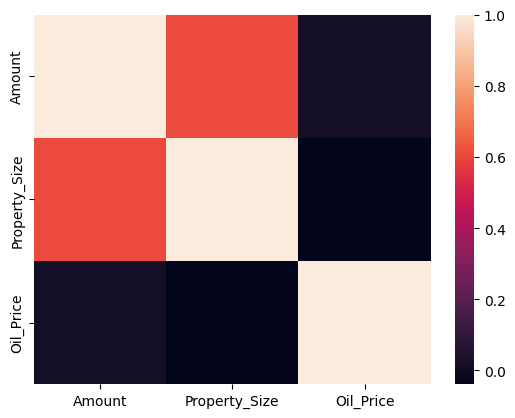

In [93]:
corr = data_try.select_dtypes("number").drop(columns=['const', 'Price_Sq_m']).corr()
sns.heatmap(corr);

#### 1A <br>
a - Берем нашу первую модель, можно добавить геопозицию <br>
б - Удобно протестировать (1. Что с площадью растет и цена 2. Что с приближением к воде растет цена) <br>
с - Можно трансформировать Y сказав, что будем прогнозировать Цена/Площадь <br>
или просто логарифмировать что-то, возвести в квадрат => сравнить модели F тестом <br>

#### 1Б <br>
д. Еще одну модель предложить?? Мне кажется можно описать модель с предыдущего шага. Описание мисспесификаций предположительных, __пока без тестов__. <br>
е. Тесты на спецификацию: <br>
Перебор разных переменных, <br>
Еще трансформации, <br>
Тест Рамзей-РЕСЕТ, CHOW TEST (structural break) <br>

ф. Предфинальная модель - нормально специфицирована - предварительная интерпритация результатов <br>

#### 2 <br>
а - проверить мультиколлиниарность - практически сделал - VIF - после можно отбросить лишние параметры <br>
б - Гетероскедастичность - Тесты есть, можно попробовать избавиться <br>
с - Эндодженеити - Описание, что потенциально может быть эндодженос <br>
д - ФИНАЛЬНАЯ МОДЕЛЬ, ИНТЕРПРИТАЦИЯ, R^2, Подтвердились ли гипотезы? <br>